### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

import sklearn 
import re

## Task 1 - Geocoding

### Write up

#### 1) Data cleansing for merging pluto and park

We review the two datasets and find out that the "pluto" dataset is pretty clean, the address format is consistent. The address format in the "park" dataset is pretty messy, and we summarize four patterns of representation inconsistency：

1. Full Spelling v.s Abbreviation of Spot. STREET--ST, AVENUE--AVE, DRIVE--DR, BROADWAY--BWAY, PLACE--PL, BOULEVARD--BLVD, LANE--LN, SQUARE--SQ. We transform from abbreviation to full spelling.

2. Full Spelling v.s Abbreviation of Direction. WEST--W, EAST--E, SOUTH--S, NORTH--N. We transform from abbreviation to full spelling.

3. Suffix of Ordinal Number. 1ST, 2ND, 3RD, 4TH. There is no suffix in pluto datatset, we delete those surfix in dataset "park".

4. Missing of Spot Name. Some addresses are short of spot name, e.g. STREET, AVENUE, etc. In all those cases, we add "STREET" in the end as "STREET" is the spot of the highest frequency.

We use regular expression module "re" on this Task. On the "park" dataset, we first find those patterns mentioned above and then replace them with the consistent representation. After processing, around 47% of total data can be matched. 

#### 2) Data cleansing for wrongly assigned precinct

We realised that some of the observations which had the same longitude and lagtitude had different precincts. For example, when we see the result of 'grouped_df' data frame, we can check when long equals to -73.911335 and lat equals to 40.870937, there are 2 data points assigned to precinct 33 and there are 130 data points assigned to precinct 34. Consideirng the high probability that precinct column is contaminated, we concluded that it is more reasonable to reassign the precinct with the right criteria. In order to reassign precincts, we counted the number of occurrences of each precinct for each set of observations with the same longitude and latitude. We then identified the precinct which had the highest proportion of occurrences and updated the precinct values of the rest of the observations in that set with that precinct value. We used gropby() and idxmax() function to calculate the proportion and checked whether all data points correctly have their precincts by using if-else statement.

#### 3) Fake data generation for precinct 22

There are only 180 data points for precinct 22 in the original sets. If a specific class is lacking of its data points compared to other classes, multiple classification methods may not work well. Therefore, we generated fake data sets for precinct 22, central park. We utilized polygon and random functions to generate 50000 data points for precinct 22, and since the median number of data points of each precinct is 67169, it concluded that 50000 data points are reasonable.

#### 4) Visualization

We used scatter plot to visualize longitude and latitude data. Labels of the precinct are added so that we can compare it to the figure that we produce in Task 2.

### Implementation

In [2]:
park = pd.read_csv("data/manh_tickets_2019.csv.zip")
pluto = pd.read_csv("data/manh_pluto.csv")

In [3]:
address_pluto = list(pluto.address.str.upper()) # The format in Pluto is clean.

In [4]:
# Define regex expression
# replace the abbreviation of spot with complete spelling (ST --> STREET; AVE --> AVENUE; DR --> DRIVE; BWAY --> BROADWAY; PL --> PLACE; BLVD --> BOULEVARD; LN --> LANE; SQ --> SQUARE)
STREET_re = re.compile(r"\bST\b|\bST$")
AVENUE_re = re.compile(r"\bAVE\b|\bAVE$|\bAV$")
DRIVE_re = re.compile(r"\bDR\b|\bDR$")
BROADWAY_re = re.compile(r"\bBWAY\b|\bBWAY$")
PLACE_re = re.compile(r"\bPL\b|\bPL$")
BLVD_re = re.compile(r"\bBLVD\b|\bBLVD$|\bBLV$")
LANE_re = re.compile(r"\bLN\b|\bLN$")
SQUARE_re = re.compile(r"\bSQ\b|\bSQ$")
AMER_re = re.compile(r"\bAMERICAS$|\bAMERICAS\b")

# replace the abbreviation of direction with complete spelling (W --> WEST; N --> NORTH; S --> SOUTH; E --> EAST)
NORTH_re = re.compile(r"\bN\b|\bN$")
SOUTH_re = re.compile(r"\bS\b|\bS$")
WEST_re = re.compile(r"\bW\b|\bW$")
EAST_re = re.compile(r"\bE\b|\bE$")

# drop off "TH", "RD", "ST", "ND" behind the number, e.g. 1ST --> 1; 32ND --> 32; 43TH --> 43; 132RD --> 132
TH_re = re.compile(r"(?<=\d)TH\b")
RD_re = re.compile(r"(?<=\d)RD\b")
ST_re = re.compile(r"(?<=\d)ST\b")
ND_re = re.compile(r"(?<=\d)ND\b")

In [5]:
address_park = list(park.address.str.upper())
# Clean the address in park to make it consistent with the address in pluto
address_park = [STREET_re.sub("STREET", addr) for addr in address_park]
address_park = [AVENUE_re.sub("AVENUE", addr) for addr in address_park]
address_park = [DRIVE_re.sub("DRIVE", addr) for addr in address_park]
address_park = [BROADWAY_re.sub("BROADWAY", addr) for addr in address_park]
address_park = [PLACE_re.sub("PLACE", addr) for addr in address_park]
address_park = [BLVD_re.sub("BOULEVARD", addr) for addr in address_park]
address_park = [LANE_re.sub("LANE", addr) for addr in address_park]
address_park = [SQUARE_re.sub("SQUARE", addr) for addr in address_park]
address_park = [AMER_re.sub("AMER", addr) for addr in address_park]

address_park = [NORTH_re.sub("NORTH", addr) for addr in address_park]
address_park = [SOUTH_re.sub("SOUTH", addr) for addr in address_park]
address_park = [WEST_re.sub("WEST", addr) for addr in address_park]
address_park = [EAST_re.sub("EAST", addr) for addr in address_park]

address_park = [TH_re.sub("", addr) for addr in address_park]
address_park = [RD_re.sub("", addr) for addr in address_park]
address_park = [ST_re.sub("", addr) for addr in address_park]
address_park = [ND_re.sub("", addr) for addr in address_park]

address_park = [addr + " STREET" if re.search(r"\d+$", addr) else addr for addr in address_park]

In [6]:
park.address = address_park # rename using clean format
data = park.merge(pluto, how = "left", on = "address")
data.dropna(inplace = True) # Drop missing value 53% (NA values are 2003742)

In [7]:
# Proportion of data matched.
print(len(data)/len(park))

0.46553679264611625


In [8]:
# the number of unique longitude, latitude pairs : This implies there are many data points with the same lat-long pairs but have different issue_date and address.
data.groupby(["lat", "long"])["precinct"].count()

lat        long      
40.700369  -74.012911     19
40.700550  -74.011588     45
40.700918  -74.014444     95
40.702153  -74.012021     57
40.702266  -74.010607    300
                        ... 
40.874625  -73.910209      1
40.876213  -73.912496      1
40.876671  -73.910908      1
40.876751  -73.912134      1
40.876767  -73.911750      3
Name: precinct, Length: 35618, dtype: int64

In [9]:
# group the data by 'long' and 'lat' and count the number of occurrences of each 'precinct' value
grouped_df = data.groupby(['long', 'lat', 'precinct']).size().reset_index(name='count')

# find the 'precinct' value with the greatest proportion for each group
max_df = grouped_df.loc[grouped_df.groupby(['long', 'lat'])['count'].idxmax()]

# merge the 'max_df' back onto the original dataset to update the 'precinct' values
df = pd.merge(data, max_df[['long', 'lat', 'precinct']], on=['long', 'lat'], how='left')

# define a new 'precinct' column which takes values from max_df. If any 'precinct' value is missing,
# fill it with the corresponding value from the original dataframe 

df['precinct'] = df['precinct_y'].fillna(df['precinct_x'])

# drop any unnecessary columns
df = df.drop(['precinct_x', 'precinct_y'], axis=1)

In [10]:
# group the data by 'long' and 'lat' and get the number of unique 'precinct' values for each group
grouped_df = df.groupby(['long', 'lat'])['precinct'].nunique().reset_index(name='n_precincts')

# get the number of groups where the number of unique 'precinct' values is greater than 1
n_inconsistent = len(grouped_df[grouped_df['n_precincts'] > 1])

if n_inconsistent == 0:
    print("All observations with the same longitude and latitude have the same precinct number.")
else:
    print(f"There are {n_inconsistent} groups of observations with the same longitude and latitude that have different precinct numbers.")

All observations with the same longitude and latitude have the same precinct number.


In [11]:
# generating 50000 fake observations from within Central Park's boundaries 

from shapely.geometry import Polygon, Point

precinct_counts = df["precinct"].value_counts()

# Central Park corners coordinates
topleft = (-73.958083, 40.800400)
topright = ( -73.949651, 40.796798)
botleft = (-73.981365, 40.767991)
botright = (-73.972975, 40.764386)

# Define the coordinates of the four corners of Central Park
central_park_corners = [botleft, botright, topright, topleft]

# Create a polygon object from the coordinates
central_park_poly = Polygon(central_park_corners)

# Define the bounding box for the polygon
min_x, min_y, max_x, max_y = central_park_poly.bounds

n_points = 50000
points = []

random.seed(123)
while len(points) < n_points:
# Generate a random point within the bounding box
    point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
    # Check if the point is within the polygon
    if central_park_poly.contains(point):
        points.append((point.x, point.y))
        
points = pd.DataFrame(points, columns=['long', 'lat'])

# Create a new dataframe with the required columns and imputed values
n_points = points.shape[0]
new_df = pd.DataFrame({
    'issue_date': np.full(n_points, '03/26/2023'),
    'violation_code': np.full(n_points, 21),
    'address': np.full(n_points, 'Central Park'),
    'lat': points['lat'],
    'long': points['long'],
    'precinct': np.full(n_points, 22)
})

# Concatenate the new dataframe with the original dataframe
df = pd.concat([df, new_df], ignore_index=True)

In [12]:
# Create midpoint of each precinct for plotting
# Get a list of all unique precinct IDs in the dataframe
precincts = df['precinct'].unique()

# Create an empty dictionary to store the mean coordinates for each precinct
mean_coords = {}

# Loop over each precinct and calculate the mean coordinate
# for precinct in precincts:
#     mean_lat = df[df['precinct'] == precinct]['lat'].mean()
#     mean_long = df[df['precinct'] == precinct]['long'].mean()
#     mean_coords[precinct] = (mean_lat, mean_long)

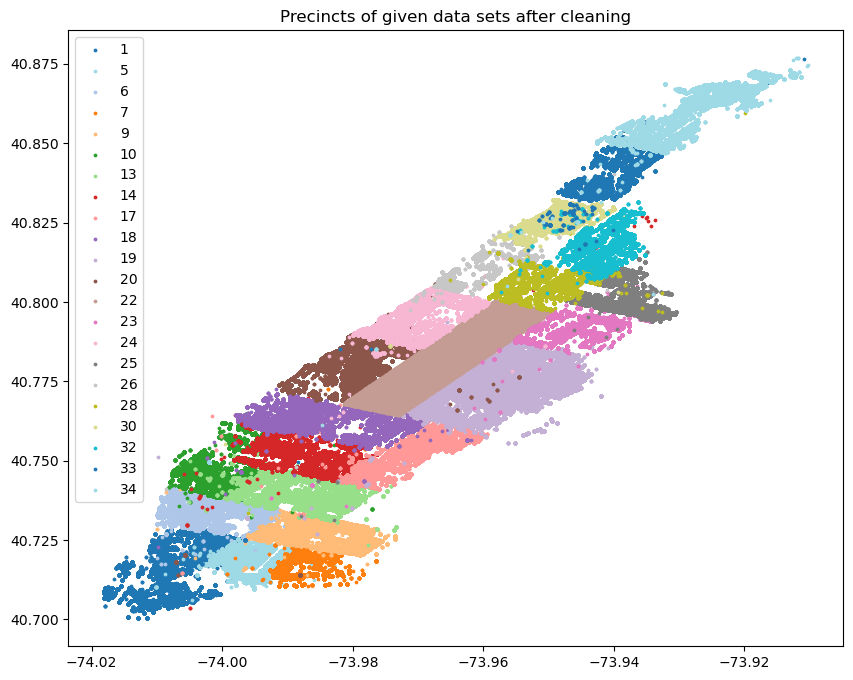

In [13]:
precinct = [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]
N = len(precinct)
style = dict(size=12, color='black')
fig, ax = plt.subplots(figsize=(10, 8))

# Define a list of N colors to use for each label
seq = np.linspace(0, 1, N)
seq[1], seq[20] = seq[20], seq[1]
colors = plt.cm.tab20(seq)

for i, label in enumerate(precinct):
    ax.scatter(df[df['precinct'] == label]['long'],
               df[df['precinct'] == label]['lat'],
               label=label, s = 3,
               color=colors[i])

for precinct, coord in mean_coords.items():
    ax.text(coord[1], coord[0], f'{precinct}', ha='center', va='center', fontsize=10)
    
plt.title("Precincts of given data sets after cleaning")
ax.legend()
plt.show()

## Task 2 - Modeling

### Write up

#### 1) Modeling preparation

(1) Selected partial data sets: Since the data sets have the huge amount of data, we first selected the partial data sets with precincts 5 and 9. With those limited precinct and data sets, we can run various models and compared them to find which was optimal in terms of accuracy and run-time. The following procedure of trying different models and choosing the best models was all conducted via this limited number of data sets with precincts 5 and 9. Just in case those chosen precincts are unintentionally special cases, when choosing the final best models with two candidates, randomforest and KNN, we tested with another chosen data sets with different precincts.

(2) Added interaction terms: Since the data sets have small amount of variables, longitude and latitude, in order to increase prediction accuracy, it might be helpful to add interaction term between longitude and latitude. So we added the interaction term 'long_lat' and compared the modeling results with interaction and wihout interaction. Most time, with various models, with interaction showed better results in terms of accuracy.

#### 2) Modeling trials

We tried several classification models on a test dataset with a few precincts. These include: Logistic Regression, Random Forests, Decision Trees, Neural Networks and k Nearest Neighbors. For those methods which required tuning of parameters, we defined a parameter grid and did a grid search to search for the parameters that gave the highest accuracy. When doing k-fold cross validation, we used the StratifiedKFold method which ensures that an equal proportion of each precinct is represented in each fold. 

(1) Logistic Regression: For logistic regression, we tried both "penalty='none' & fit_intercept=False" and "multi_class='multinomial' & solver='lbfgs'". They both showed similar results with accuracy 53%. We concluded that this modeling is not that that suitable for our case.

(2) Random Forests : For random forest, we used param_grid={"modle":[DecisionTreeClassifier(), RandomForestClassifier()]}, "criterion": ["gini", "entropy"] and "max_depth": [2,3,4,5,6,7], cv = KFold(5, shffle=True, random_state=1234). With interaction term, the accuracy was 98.368% and without interaction term, the accuracy was 98.365%. So we concluded that the model with interaction term works better. Even though the accuracy was very high the compuation time was also very long. 

(3) Decision Trees: For decisiontree methods, we used the param_grid with "criterion": ["gini", "entropy"] and "max_depth": [2,3,4,5,6,7], cv = KFold(5, shffle=True, random_state=1234) and scoring="accuracy". The final result showed that entropy with max_depth=7 are the best classifier with the accuracy 98%. The accuracy with interaction was 98.423% and without interaction was 98.417%. So we can concluded that via Decision trees, with interaction is a better model. Like the random forest model, even though the accuracy was very high the compuation time was very long. 

(4) Neural Networks: For neural networks, the param_grid we defined had "hidden_layer_sizes": [(10,), (20,), (30,), (40,)], "activation": ['relu', 'logistic'] and "alpha":[0.0001, 0.001, 0.01, 0.1]. GridSearch selected "hidden_layer_sizes" as (20,), "activation" as 'relu' and "alpha" as 0.0001. The accuracy was high but not as high as random forests and kNN and moreover, the computation time was fairly long. Therefore, we did not choose Neural Networks as our final model

(5) k Nearest Neighbors: For k Nearest Neighbors, param_grid had "n_neighbors": [3, 5 ,7, 9, 11, 13, 15, 17, 19, 21, 25] and "metric": ['euclidean','manhattan', 'minkowski','hamming']. The accuracy was extremely high at 99.97% on our sample dataset containing precincts 5 and 9. Also, the computation time was superior compared to the nearest competitior model in terms of accuracy (random forests). Therefore, we decided to choose kNN as our final model. 

#### 3) Choosing the final model (KNN)

Out of the methods we tried, k Nearest Neighbors had the best performance on our sample dataset containing data from precincts 5 and 9. We also added an interaction term between longitude and latitude and discovered that this improved performance marginally. 

We found in that based on the dataset that we created in Task1, there are many data points have the same 'longitude' and 'latitude' pairs. For example, when we run duplicated(subset=['long', 'lat']), the result is saved with the name 'duplicates', we can find that there are 134987 data points with the same lat 40.706667, long -74.018164 and precinct 1. This presents a problem for the kNN algorithm, because the nearest neighbors for such points will be the points themselves. Therefore, in order to optimise the algortihm, we decide to delete the duplicated data so that we only have a single observation for each 'longitude' and 'latitude' pair. We also believe that doing this will help prevent overfitting in the kNN model. 

Regarding the parameter grid for hyperparameter tuning which will be used by GridSearch to select the optimal parameters. A smaller value for ‘n_neighbours’ tends to overfit while a higher value tends to underfit. Initially we tested a smaller range of values from 9 to 25 and found that GridSearch was selecting ‘9’ which was the lower boundary point so we extended the range of possible values to include ‘3’, ‘5’ and ‘7’. ‘metric’ refers to the way distance is computed. e.g., manhattan distance is found by taking the sum of the absolute differences in the Cartesian coordinates between two points.

The final metric and confusion matrix can be shown with sklearn.metrics and ConfusionMatrixDisplay. We first present our accuracy using our optimised model (where we deleted observations) and achieve an accuracy of 94.44% and then we present our accuracy using the full dataset with an accuracy of 94.04%. 

### Implementation

In [14]:
# long lat interaction
df['long_lat'] = df['long'] * df['lat']

#### Handling duplicate data points

In [15]:
# delete observations with the same longitude and latitude (this will prevent the kNN model from identifying the 
# same point as its nearest neighbor)
# identify duplicates based on the 'long' and 'lat' columns
duplicates = df[df.duplicated(subset=['long', 'lat'], keep=False)].sort_values(by=['long', 'lat'])
duplicates[duplicates['precinct']==1]

,issue_date,violation_code,address,lat,long,precinct,long_lat
19845,07/25/2018,14,50 BATTERY PLACE,40.706667,-74.018164,1,-3013.032779
23231,06/21/2018,14,50 BATTERY PLACE,40.706667,-74.018164,1,-3013.032779
33023,07/05/2018,21,50 BATTERY PLACE,40.706667,-74.018164,1,-3013.032779
97648,07/11/2018,46,50 BATTERY PLACE,40.706667,-74.018164,1,-3013.032779
97690,07/13/2018,46,50 BATTERY PLACE,40.706667,-74.018164,1,-3013.032779
...,...,...,...,...,...,...,...
821449,12/14/2018,69,124 BOWERY,40.718727,-73.995054,1,-3012.984374
7756,06/30/2018,38,63 EAST 11 STREET,40.733040,-73.992098,1,-3013.923102
1022814,01/18/2019,31,63 EAST 11 STREET,40.733040,-73.992098,1,-3013.923102
360002,09/22/2018,38,245 EAST HOUSTON STREET,40.721687,-73.985508,1,-3012.814730


In [16]:
# keep only the first occurrence of each group of duplicates
df2 = df.drop_duplicates(subset=['long', 'lat'], keep='first')

In [17]:
df2.groupby(['precinct']).count()

,issue_date,violation_code,address,lat,long,long_lat
precinct,,,,,,
1,1835,1835,1835,1835,1835,1835
5,1550,1550,1550,1550,1550,1550
6,2326,2326,2326,2326,2326,2326
7,852,852,852,852,852,852
9,2091,2091,2091,2091,2091,2091
10,1331,1331,1331,1331,1331,1331
13,2019,2019,2019,2019,2019,2019
14,1357,1357,1357,1357,1357,1357
17,1543,1543,1543,1543,1543,1543


In [18]:
# randomly delete 47000 samples with precinct equal to 22 so that it is of a roughly same size compared to the other
# precincts
rows_to_delete = df2[df2['precinct'] == 22].index
rows_to_keep = np.random.choice(rows_to_delete, size=len(rows_to_delete)-47000, replace=False)
delete = [False if row in rows_to_keep else True for row in rows_to_delete]
rows_to_delete = rows_to_delete[delete]
df3 = df2.drop(rows_to_delete)

In [19]:
# After processing, there are less than 40,000 samples left. By reducing the number of datapoints while retaining
# the same anount of information (since we only keep the points which have unique longitude and latitude), we are 
# able to get a good result with a shorter run-time.
len(df3)

38618

In [20]:
df3.groupby(['precinct']).count() #averaeg number of data points of each precinct 1755

,issue_date,violation_code,address,lat,long,long_lat
precinct,,,,,,
1,1835,1835,1835,1835,1835,1835
5,1550,1550,1550,1550,1550,1550
6,2326,2326,2326,2326,2326,2326
7,852,852,852,852,852,852
9,2091,2091,2091,2091,2091,2091
10,1331,1331,1331,1331,1331,1331
13,2019,2019,2019,2019,2019,2019
14,1357,1357,1357,1357,1357,1357
17,1543,1543,1543,1543,1543,1543


#### Final KNN modeling

In [21]:
# full dataset
X = df3[['long', 'lat', 'long_lat']]
y = df3['precinct']

In [22]:
# kNN

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = {
    'n_neighbors': [3, 5 ,7, 9, 11, 13, 15, 17, 19, 21, 25],
    'metric': ['euclidean','manhattan', 'minkowski','hamming'],
    },
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
).fit(X,y)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best accuracy: 0.9171112999680215


In [23]:
# Compute the accuracy on the training data.
prediction = grid_search.best_estimator_.predict(X)
acc = sum(prediction == y)/len(y)
acc

0.9444041638614118

In [36]:
# we compute the accuracy on the full dataset in order to provide a fair comparison with other models that are trained 
# using the full dataset and give a full display of our model's performance.
X_full = df[['long', 'lat', 'long_lat']]
y_full = df['precinct']
prediction_full =  grid_search.best_estimator_.predict(X_full)
acc_full = sum(prediction_full == y_full)/len(y_full)
acc_full

0.9403983757294557

In [24]:
# metrics for each precinct
print(
    classification_report(y, prediction)
)

              precision    recall  f1-score   support

           1       0.97      0.97      0.97      1835
           5       0.96      0.96      0.96      1550
           6       0.96      0.97      0.96      2326
           7       0.94      0.96      0.95       852
           9       0.97      0.98      0.97      2091
          10       0.92      0.90      0.91      1331
          13       0.94      0.93      0.93      2019
          14       0.88      0.85      0.86      1357
          17       0.91      0.91      0.91      1543
          18       0.92      0.94      0.93      1834
          19       0.97      0.98      0.98      5086
          20       0.97      0.95      0.96      2224
          22       0.98      0.99      0.98      3001
          23       0.97      0.84      0.90      1126
          24       0.94      0.96      0.95      1854
          25       0.90      0.95      0.92      1395
          26       0.92      0.81      0.86       537
          28       0.90    

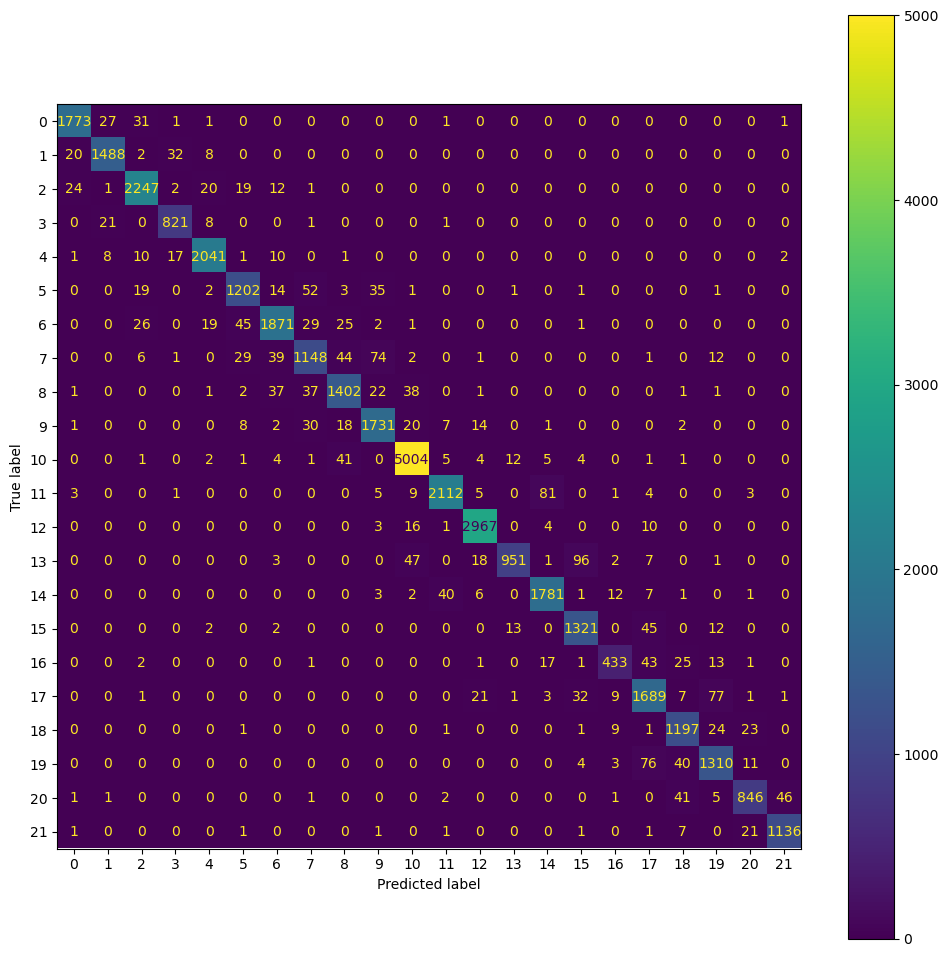

In [28]:
cm = confusion_matrix(y, prediction, labels=grid_search.classes_)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm).plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(12)
fig.set_figheight(12)  
plt.show()

## Task 3 - Visualization

Based on our accuracy rate, and the comparison between the visualization map of the original data and the visualization map of the predicted data, it can be shown that our model's performance is good enough to clearly identify the precincts in manhattan.

In [29]:
pred = pd.read_csv("data/manh_pred.csv")
bound = pd.read_csv("data/manh_bound.csv")

In [30]:
# long lat interaction
pred['long_lat'] = pred['long'] * pred['lat']

In [31]:
# full dataset
X_pred = pred[['long', 'lat', 'long_lat']]

In [32]:
task3_prediction = grid_search.best_estimator_.predict(X_pred)
pred['precinct'] = task3_prediction

In [33]:
# Create midpoint of each precinct for plotting (same with task1)
precincts2 = pred['precinct'].unique()
mean_coords2 = {}
for precinct in precincts2:
    mean_lat = pred[pred['precinct'] == precinct]['lat'].mean()
    mean_long = pred[pred['precinct'] == precinct]['long'].mean()
    mean_coords2[precinct] = (mean_lat, mean_long)

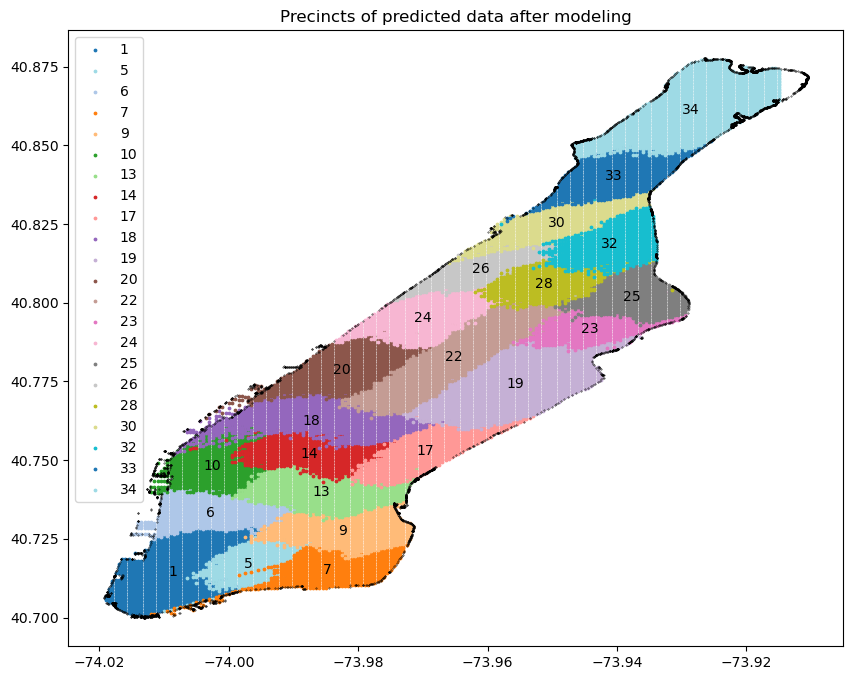

In [34]:
# Plot the data
precinct = [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]
N = len(precincts)
style = dict(size=12, color='black')
fig, ax = plt.subplots(figsize=(10, 8))

# Define a list of N colors to use for each label
seq = np.linspace(0, 1, N)
seq[1], seq[20] = seq[20], seq[1]
colors = plt.cm.tab20(seq)

for i, label in enumerate(precinct):
    ax.scatter(pred[pred['precinct'] == label]['long'],
               pred[pred['precinct'] == label]['lat'],
               label=label, s = 3,
               color=colors[i])

for precinct, coord in mean_coords2.items():
    ax.text(coord[1], coord[0], f'{precinct}', ha='center', va='center', fontsize=10)
    
plt.title("Precincts of predicted data after modeling")
ax.scatter(bound.long, bound.lat, c="k", s=0.1)
ax.legend()
plt.show()